# 0. Librerías

Cargamos las librerias necesarias para ejecutar el cuaderno.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Load: Exploración del alquiler de bicicletas

Exploramos el dataset de Bikeshare para entender cómo el clima, la estacionalidad y los días festivos afectan la demanda de bicicletas.

Este dataset viene de serie con cierto tratamiento de los datos (ej.: la normalización de las temperaturas, humedad, velocidad del viento...)

In [2]:
# Carga del dataset por hora
df = pd.read_csv("../data/hour.csv")
# Leemos las primeras entradas del dataset
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Descripción de las columnas del dataset

El archivo `/data/readme.txt` aporta información sobre las columnas presentes en el dataset.

- **instant**: índice del registro
- **dteday**: fecha
- **season**: estación (1: primavera, 2: verano, 3: otoño, 4: invierno)
- **yr**: año (0: 2011, 1: 2012)
- **mnth**: mes (1 a 12)
- **hr**: hora (0 a 23)
- **holiday**: si el día es festivo (1) o no (0)
- **weekday**: día de la semana (0: domingo, 6: sábado)
- **workingday**: si es día laboral (1) o no (0)
- **weathersit**: situación climática (1: Despejado, 2: Niebla/Nubes, 3: Lluvia ligera/Nieve, 4: Lluvia intensa/Nieve)
- **temp**: temperatura normalizada (dividida por el valor max 41)
- **atemp**: sensación térmica normalizada (dividida por el valor max 50)
- **hum**: humedad normalizada (dividida por 100, tanto por 1)
- **windspeed**: velocidad del viento normalizada (dividida por el valor max 67)
- **casual**: número de usuarios ocasionales
- **registered**: número de usuarios registrados
- **cnt**: total de alquileres de bicicletas (casual + registrados)


# 2. Data Wrangling: Revisión y transformación de columnas.

Puesto que el dataset contiene varias columnas con valores normalizados y nuestro objetivo en este notebook es realizar una exploración descriptiva (no preparar los datos para un modelo predictivo concreto), vamos a realizar los siguientes pasos para facilitar la interpretación de los resultados:

- Renombrar las columnas para que sean más comprensibles.
- Desnormalizar las columnas que contienen valores escalados, devolviéndolas a sus unidades originales.
- Crear un índice temporal a partir de la fecha y la hora.
- Eliminar columnas que no son necesarias para el análisis exploratorio.
- Eliminar entradas duplicadas a partir del ínidice temporal.
- Eliminar posibles outliers dentro de un rango de interquartiles.

Estas transformaciones permitirán interpretar los datos de manera más clara y realizar visualizaciones más informativas.

In [3]:
# Renombramos columnas para facilitar su comprensión
df = df.rename(columns={
    "instant": "instante",
    "dteday": "fecha",
    "season": "estacion",
    "yr": "año",
    "mnth": "mes",
    "hr": "hora",
    "holiday": "festivo",
    "weekday": "dia_semana",
    "workingday": "dia_laboral",
    "weathersit": "sit_meteorologica",
    "hum": "norm_hum",
    "temp": "norm_temp",
    "atemp": "norm_atemp",
    "windspeed": "norm_windspeed",
    "casual": "casual",
    "registered": "registrado",
    "cnt": "num_usuarios"
})

In [4]:
# Desnormalizamos las columnas previamente normalizadas
df["temperatura"] = (df["norm_temp"] * 41).round(1) # en grados Celsius
df["temperatura_sensacion"] = (df["norm_atemp"] * 50).round(1) # en grados Celsius
df["humedad"] = (df["norm_hum"] * 100).round(2) # en porcentaje
df["velocidad_viento"] = (df["norm_windspeed"] * 67).round(2) # en Km/h

In [5]:
# Convertimos la columna 'dteday' a tipo datetime
df["timestamp"] = pd.to_datetime(df["fecha"]) + pd.to_timedelta(df["hora"], unit="h")
df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%d %H:%M")
df = df.set_index("timestamp")

In [6]:
# Eliminamos columnas innecesarias por ahora
df = df.drop(columns=["instante", "año", "mes", "hora", "fecha", "norm_temp", "norm_atemp", "norm_hum", "norm_windspeed"], axis=1)

In [7]:
# Mostrar filas duplicadas
duplicados = df[df.index.duplicated()]
duplicados

# Eliminar duplicados del dataset
df = df[~df.index.duplicated()]

In [8]:
# Eliminar outliers fuera del rango intercuartílico para todas las columnas numéricas
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Nos quedamos solo con los datos dentro del rango permitido para todas las columnas numéricas
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

## Descripción del dataset

Una vez seleccionadas las columnas necesarias para el análisis, vamos a ver una descripción de los valores que presentan cada una.

In [9]:
# Crear un DataFrame resumen con info y nunique
info = pd.DataFrame({
    "tipo": df.dtypes,
    "nulos": df.isnull().sum(),
    "n_unique": df.nunique()
})
info

,tipo,nulos,n_unique
estacion,int64,0,4
festivo,int64,0,1
dia_semana,int64,0,7
dia_laboral,int64,0,2
sit_meteorologica,int64,0,3
casual,int64,0,115
registrado,int64,0,499
num_usuarios,int64,0,581
temperatura,float64,0,50
temperatura_sensacion,float64,0,65


El DataFrame anterior aporta la siguiente información:

- No hay valores nulos ni NaNs.
- El tipo de datos de cada columna (int64 o float64) es el adecuado para su contenido.
- Los valores únicos de las columnas `estacion`, `festivo`, `dia_semana`, `dia_laboral` y `sit_meteorologica` coinciden con la información proporcionada en el archivo `Readme.txt`. Estas variables parecen ser categóricas y, probablemente, se les aplicó un one-hot encoding previamente.

In [10]:
# Resumen estadístico del DataFrame
df.describe().round(2)

,estacion,festivo,dia_semana,dia_laboral,sit_meteorologica,casual,registrado,num_usuarios,temperatura,temperatura_sensacion,humedad,velocidad_viento
count,14799.00,14799.0,14799.00,14799.00,14799.00,14799.00,14799.00,14799.00,14799.00,14799.00,14799.00,14799.00
mean,2.49,0.0,3.02,0.73,1.44,23.77,125.06,148.83,19.82,23.22,64.50,12.07
std,1.12,0.0,1.95,0.44,0.65,26.52,113.95,131.38,7.83,8.52,18.87,7.49
min,1.00,0.0,0.00,0.00,1.00,0.00,0.00,1.00,0.80,0.00,8.00,0.00
25%,1.00,0.0,1.00,0.00,1.00,3.00,28.00,33.00,13.10,15.90,50.00,7.00
50%,2.00,0.0,3.00,1.00,1.00,13.00,100.00,120.00,19.70,23.50,65.00,11.00
75%,3.00,0.0,5.00,1.00,2.00,37.00,186.00,229.00,26.20,30.30,81.00,17.00
max,4.00,0.0,6.00,1.00,3.00,114.00,499.00,594.00,41.00,50.00,100.00,31.00


Todos los valores estadisticos mostrados en la tabla contienen valores normales dentro de sus rango.

# 3. Data Visualization: Relaciones a partir de gráficos

## Distribución de la demanda de bicicletas


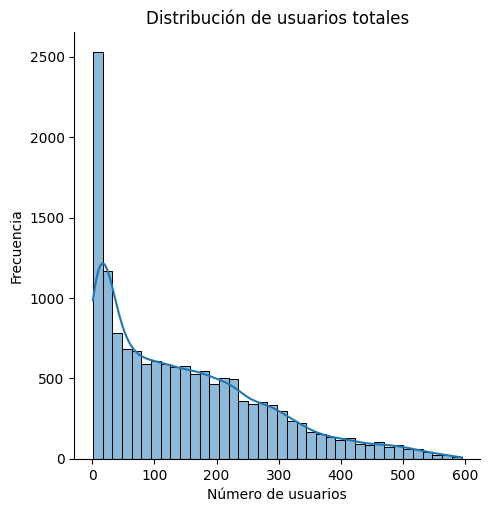

In [11]:
# Visualización de la distribución de usuarios totales
sns.displot(
    data=df,
    x="num_usuarios",
    kde=True,
)
plt.title('Distribución de usuarios totales')
plt.xlabel('Número de usuarios')
plt.ylabel('Frecuencia')
plt.show()

In [15]:
import plotly.figure_factory as ff

fig = ff.create_distplot([df["num_usuarios"]], group_labels=["Usuarios"], show_hist=False, show_rug=False)
fig.update_layout(
    title="Distribución de usuarios totales",
    xaxis_title="Número de usuarios",
    yaxis_title="Densidad"
)
fig.show()

## Relación entre variables climáticas y la demanda

In [13]:
fig1 = px.scatter(df, x='temperatura', y='num_usuarios', title='Temperatura vs Alquileres')
fig2 = px.scatter(df, x='humedad', y='num_usuarios', title='Humedad vs Alquileres')
fig3 = px.scatter(df, x='windspeed', y='num_usuarios', title='Viento vs Alquileres')
fig1.show()
fig2.show()
fig3.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['estacion', 'festivo', 'dia_semana', 'dia_laboral', 'sit_meteorologica', 'casual', 'registrado', 'num_usuarios', 'temperatura', 'temperatura_sensacion', 'humedad', 'velocidad_viento'] but received: windspeed

## Efecto del día de la semana, estación y feriados

In [ ]:
fig = px.box(df, x='weekday', y='num_usuarios', title='Alquileres por día de la semana')
fig.show()
fig = px.box(df, x='season', y='num_usuarios', title='Alquileres por estación')
fig.show()
fig = px.box(df, x='holiday', y='num_usuarios', title='Alquileres en días festivos vs normales')
fig.show()

## Matriz de correlación entre variables

In [ ]:

corrs = df[['temp', 'atemp', 'hum', 'windspeed', 'num_usuarios']].corr().round(2)
fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.values,
    colorscale='Viridis')
fig.update_layout(title='Matriz de correlación')
fig.show()